# 2. (Deep) CNNs for Image Colorization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
#import cv
from keras.models import Sequential, load_model, Model
from keras.layers import Reshape,Input, Dense,BatchNormalization, Activation, LeakyReLU, add,Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.optimizers import Adam,SGD
opt = Adam(lr=0.1)
import keras
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


### (a) This assignment uses a convolutional neural network for image colorization which turnsagrayscaleimagetoacoloredimage.4 Byconvertinganimagetograyscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [2]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

**Answer**: The dataset was loaded directly from the Keras Package.

### (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [3]:
ind_birds=np.argwhere(y_train==2)
ind_birds=np.delete(ind_birds,1,1).reshape(5000,)
X_train=X_train[ind_birds]
ind_bird_test=np.argwhere(y_test==2)
ind_bird_test=np.delete(ind_bird_test,1,1).reshape(1000,)
X_test=X_test[ind_bird_test]
del y_test,y_train

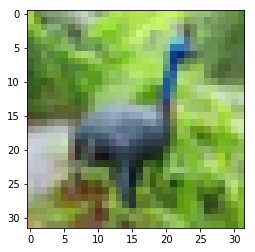

In [5]:
plt.imshow(X_train[0])
plt.show()

**Answer**: The class 'birds' is the class number 2 and the images are extracted.

### (c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

In [6]:
X=X_train.reshape(5120000,3)

**Answer**: The training set pixels are selected for training the clustering algorithm. They are reshaped to 3 elements.

### (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [40]:
km=KMeans(n_clusters=4,init='random',max_iter=1000)
km.fit(X)
center=km.cluster_centers_
center=np.array(center,dtype=np.uint)
y_clust=km.predict(X)
Xc=np.zeros((5120000,3),dtype=np.float64)
for i in range(0,y_clust.shape[0]):
    Xc[i]=center[y_clust[i]]  
Xc_test=np.zeros((1024000,3),dtype=np.float64)
y_clust1=km.predict(X_test.reshape(1024000,3))
for i in range(0,y_clust1.shape[0]):
    Xc_test[i]=center[y_clust1[i]] 

In [7]:
km=KMeans(n_clusters=4,init='random',max_iter=1000)
km.fit(X)
center=km.cluster_centers_
center=np.array(center,dtype=np.uint)
y_clust=km.predict(X)
Xc=np.zeros((5120000,3),dtype=np.float64)
for i in range(0,y_clust.shape[0]):
    Xc[i]=center[y_clust[i]]  
Xc_test=np.zeros((1024000,3),dtype=np.float64)
y_clust1=km.predict(X_test.reshape(1024000,3))
for i in range(0,y_clust1.shape[0]):
    Xc_test[i]=center[y_clust1[i]] 

In [34]:
from keras.utils.np_utils import to_categorical
y_clust=to_categorical(y_clust)
y_clust1=to_categorical(y_clust1)
y_train=y_clust.reshape(5000,1024,4)
y_test=y_clust1.reshape(1000,1024,4)

In [8]:
from keras.utils.np_utils import to_categorical
y_clust=to_categorical(y_clust)
y_clust1=to_categorical(y_clust1)
y_train=y_clust.reshape(5000,1024,4)
y_test=y_clust1.reshape(1000,1024,4)

In [39]:
print(center)

[[156 154 134]
 [108 107  82]
 [ 48  49  38]
 [205 211 210]]


**Answer**: These are the centers of the cluster. They represent the k classes for the pixels.

### (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

In [27]:
X_gray=rgb2gray(X_train).reshape(5000,32,32,1)
Xc=Xc.reshape((5000,3072))
X_gtest=rgb2gray(X_test).reshape(1000,32,32,1)
Xc_test=Xc_test.reshape(1000,3072)

In [9]:
X_gray=rgb2gray(X_train).reshape(5000,32,32,1)
Xc=Xc.reshape((5000,3072))
X_gtest=rgb2gray(X_test).reshape(1000,32,32,1)
Xc_test=Xc_test.reshape(1000,3072)

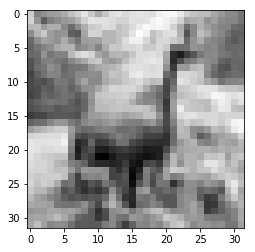

In [50]:
plt.imshow(X_gray[0].reshape(32,32))

**Answer** The images were converted to grayscale using skimage package.

### (f) Set up a deep convolutional neural network with two convolution layers and two MLP layers with. Use 5 × 5 filters and a softmax layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Your input is a grayscale version of an image (32 × 32 × 1) and the output is a 32 × 32 × 3 image that is colored using the main colors. Use a classification scheme, which means your output must determine one of the k color classes for each pixel in your grayscale image. Train at least for 5 epochs. Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 48s 11ms/step - loss: 0.6352 - acc: 0.0084 - val_loss: 0.6425 - val_acc: 0.0035
Epoch 2/10
4500/4500 [==============================] - 43s 10ms/step - loss: 0.6100 - acc: 0.0087 - val_loss: 0.6481 - val_acc: 0.0035
Epoch 3/10
4500/4500 [==============================] - 48s 11ms/step - loss: 0.6054 - acc: 0.0087 - val_loss: 0.6418 - val_acc: 0.0035
Epoch 4/10
4500/4500 [==============================] - 48s 11ms/step - loss: 0.6027 - acc: 0.0087 - val_loss: 0.6401 - val_acc: 0.0035
Epoch 5/10
4500/4500 [==============================] - 47s 10ms/step - loss: 0.6006 - acc: 0.0087 - val_loss: 0.6319 - val_acc: 0.0035
Epoch 6/10
4500/4500 [==============================] - 48s 11ms/step - loss: 0.5993 - acc: 0.0087 - val_loss: 0.6310 - val_acc: 0.0035
Epoch 7/10
4500/4500 [==============================] - 46s 10ms/step - loss: 0.5984 - acc: 0.0087 - val_loss: 0.6264 - val_acc: 0.0035
E

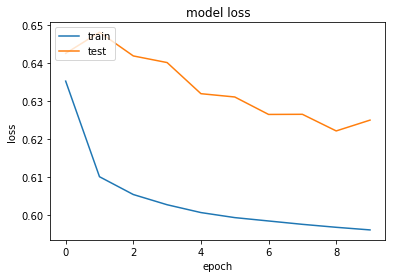

In [43]:
model=Sequential()
model.add(Conv2D(32,strides=1, kernel_size=(5, 5), input_shape=(32, 32), padding='same', activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
model.add(Conv2D(64,strides=(5,5), kernel_size=(5, 5), padding='same', activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense((),activation='relu',kernel_initializer='RandomUniform'))
model.add(Dense(3072,activation='relu'))
#model.add(Conv2D(1024, (3, 3), padding='same'))
model.load_weights('model.h5')
model.compile(loss='categorical_crossentropy', optimizer=opt)
#model.add(MaxPooling2D(pool_size=(2, 2),strides=None,padding='same'))
history = model.fit(X_gray, Xc,
                    batch_size=64,
                    epochs=5,
                    verbose=1,
                    shuffle=True,validation_split=0.1)
model.save_weights('model.h5')
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

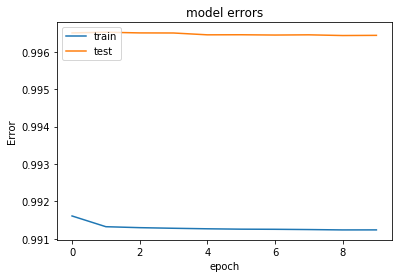

In [46]:
plt.plot(1-np.array(history.history['acc']))
plt.plot(1-np.array(history.history['val_acc']))
plt.title('model errors')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Answer** Test and training error were plotted.

In [52]:
prediction=model.predict(X_gtest)
prediction=prediction.reshape(1000,32,32,4)
pred=np.zeros((1000,32,32,3),dtype=np.float64)
for i in range(0,1000):
    for j in range(0,32):
        for k in range(0,32):
            pred[i][j][k]=center[np.argmax(prediction[i][j][k])]        

In [39]:
def showOrigDec(xtest, pred, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax1 = plt.subplot(2, n, i+1)
        plt.imshow(xtest[i].reshape(32, 32, 3))
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)

        # display reconstruction
        ax1 = plt.subplot(2, n, i +1 + n)
        plt.imshow(pred[i].reshape(32, 32, 3))
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
    plt.show()

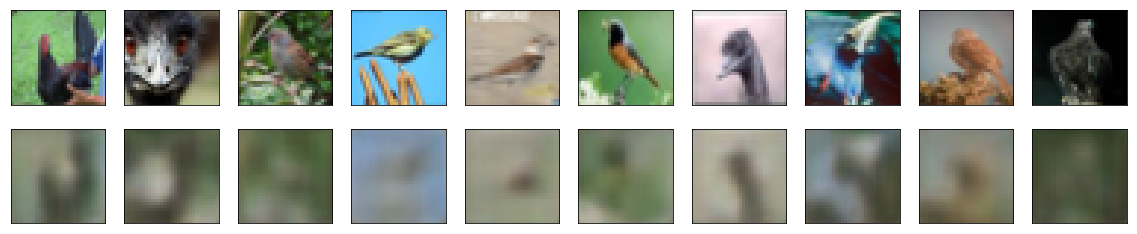

In [45]:
prediction=model.predict(X_gtest)
prediction=prediction.reshape(1000,32,32,4)
pred=np.zeros((1000,32,32,3),dtype=np.float64)
for i in range(0,1000):
    for j in range(0,32):
        for k in range(0,32):
            pred[i][j][k]=center[np.argmax(prediction[i][j][k])] 
showOrigDec(X_test[:10],pred[:10]) 

**Answer** The  first 10 test images were plotted.